<a href="https://colab.research.google.com/github/OCRC/TreinamentoSingleCell/blob/main/pbmc3k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pré-processamento e clusterização de 3 mil PBMCs (células circulantes do plasma periférico)

Esse tutorial visa explicar como podemos sair de um arquivo cheio de números e letras pouco palpáveis que são o resultado de um sequenciamento de single-cell, e transformá-lo nas imagens interessantes e muito elucidativas dos estudos de single-cell.

Estamos aqui utilizando a linguagem de programação Python. Utilizamos como base o tutorial do [Scanpy](https://scanpy-tutorials.readthedocs.io/en/latest/index.html), que por sua vez teve como base o método de [Seurat](http://satijalab.org/seurat/pbmc3k_tutorial.html) ([Satija et al., 2015](https://doi.org/10.1038/nbt.3192).

Os dados que analizaremos consiste em 3 mil células de doadores saudáveis sequenciadas em single-cell que estão disponíveis no site da [10x Genomics]((https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k).

Os dados estão organizados em matrizes, que geralmente vem compactadas em um único arquivo.

Abaixo, vamos criar uma pasta **data**, baixar os dados do site e descompactá-los para termos acesso as suas matrizes. Vamos ainda criar uma segunda pasta, **write**, para colocarmos nossos resultados

In [1]:
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
!mkdir write

mkdir: cannot create directory ‘data’: File exists
--2021-01-21 20:33:37--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2021-01-21 20:33:37--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

data/pbmc3k_filtere 100%[===================>]   7.27M  28.7MB/s    in 0.3s    

2021-01-21 20:33:3

É bastante difícil trabalhar diretamente com essas matrizes de dados. Imagina se fóssemos abrir ela no excel: uma planilha com mais de 3 mil linhas!

Para facilitar, bioinformatas desenvolveram ferramentas que nos ajudam a manusear essas matrizes. Essas ferramentas são chamadas de funções.

Para utilizarmos essa funções, precisamos instalar alguns pacotes e colocar esses pacotes no programa (ou seja, importá-los)

In [2]:
!pip install numpy
!pip install scanpy
import numpy as np
import pandas as pd
import scanpy as sc

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white', format='tif')

scanpy==1.6.1 anndata==0.7.5 umap==0.4.6 numpy==1.19.5 scipy==1.4.1 pandas==1.1.5 scikit-learn==0.22.2.post1 statsmodels==0.10.2 python-igraph==0.8.3 leidenalg==0.8.3


O comando abaixo cria um arquivo na nossa pasta **write**, que vai se chamar PBMC3k, onde serão armazenados os resultados do processamento que faremos

In [4]:
results_file = 'write/pbmc3k.h5ad'  # the file that will store the analysis results

O comando abaixo chama a função que vai fazer a leitura da nossa matriz de dados. Dentro do nosso programa, esses dados ficarão armazenados na nossa variável chamada **adata**

In [5]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [6]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

O comando abaixo nos mostra o que está dentro da variável **adata**. Se tudo deu certo nos comando acima, devemos ter as 3 mil células.

In [7]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

## Pré-processamento

O comando abaixo mostra os genes que tem a maior fração de contagem em cada célula, entre as 3 mil células. Lembrando que as células são analisadas individualmente (single-cell)

normalizing counts per cell
    finished (0:00:00)


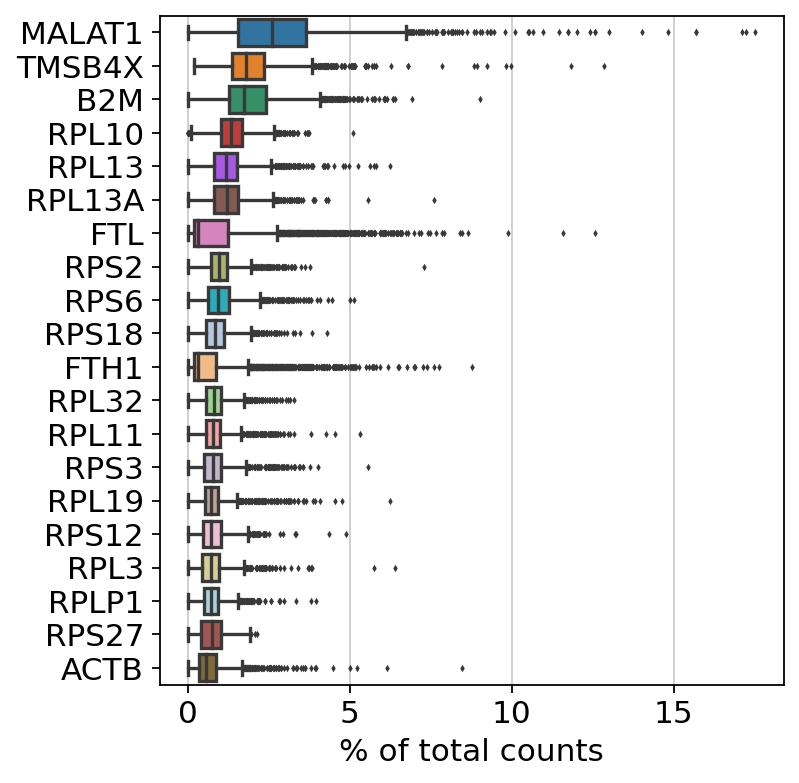

In [8]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Aqui começa nosso pré-processamento. Pensando que o resultado do processamento desses dados gerará um estudo científico, devemos descartar os dados que não são estatísticamente relevantes. Assim, faremos uma filtragem das células que tem um mínimo de genes expressos, bem como genes que são expressos em um mínimo de células

In [9]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


Precisamos fazer um controle de qualidade dos dados, para saber se temos um sequenciamento single-cell de qualidade, isto é, que seja confiável. Um dos modos de fazer isso é através da medição dos genes mitocondriais. 

Citando o workflow de "Simple Single Cell" [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics):

> Altas proporções são indicativas de células de baixa qualidade (Islam et al. 2014; Ilicic et al. 2016), possivelmente devido à perda de RNA citoplasmático de células perfuradas [no sequenciamento]. O raciocínio é que as mitocôndrias são maiores do que as moléculas transcritas individuais e têm menos probabilidade de escapar através de rupturas na membrana celular.

Com o  `pp.calculate_qc_metrics`, podemos calcular vários parâmetros de qualidade de maneira bem eficiente. 

In [10]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

Podemos plotar um gráfico de violino (violin plot) de algum desses parâmetros  de qualidade:

* O número de genes expressados por célula
* O total de contagens por célula
* O percentual de genes mitocondriais dessa contagem

In [11]:
adata

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

/usr/local/lib/python3.6/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/local/lib/python3.6/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/local/lib/python3.6/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/local/lib/python3.6/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/local/lib/python3.6/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/local/lib/python3.6/dist-packages/seaborn/_core.py

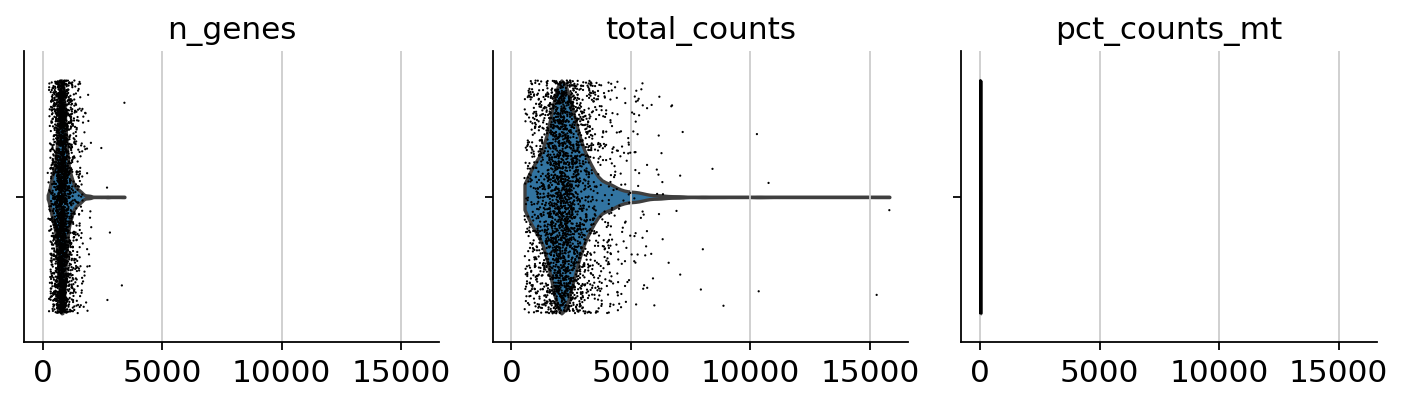

In [12]:
sc.pl.violin(adata, ['n_genes', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

Agora vamos remover as células que possuem muitos genes mitocondriais expressos ou que tem muitos genes expressos. Para saber onde devemos cortar, podemos gerar os gráficos a seguir, com os parâmetros calculados.

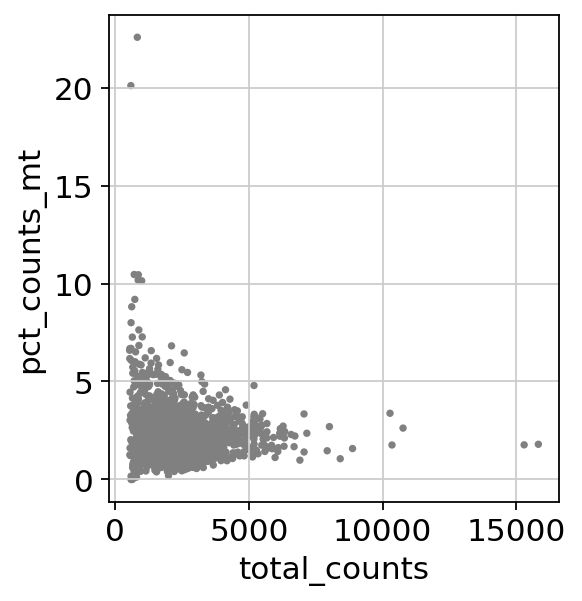

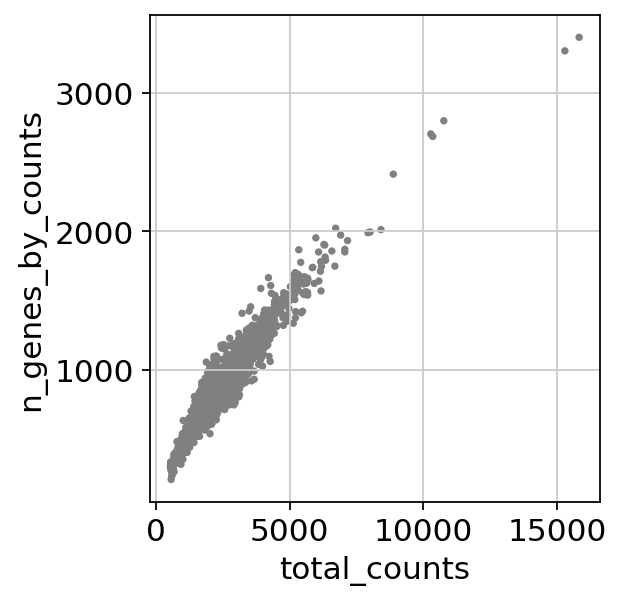

In [13]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Então fazemos a filtragem removendo essas células da nossa variável **adata**

In [14]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

O próximo passo envolve a normalização dos dados. Sabemos que como o sequencimento é um fruto de um experimento, esse está sujeito a preseça de *outliners*. Para evitar esse viés, normalizamos nossos dados, isso é, definimos que um número de contagens que julgamos ser desejável (o padrão é de 10 mil contagens por célula) e removemos o que difere muito disso. Assim, as comparações entre as células fica mais confiável.

In [15]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Aplicamos o logaritmo

In [16]:
sc.pp.log1p(adata)

Identificamos os genes altamente variáveis.

In [17]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


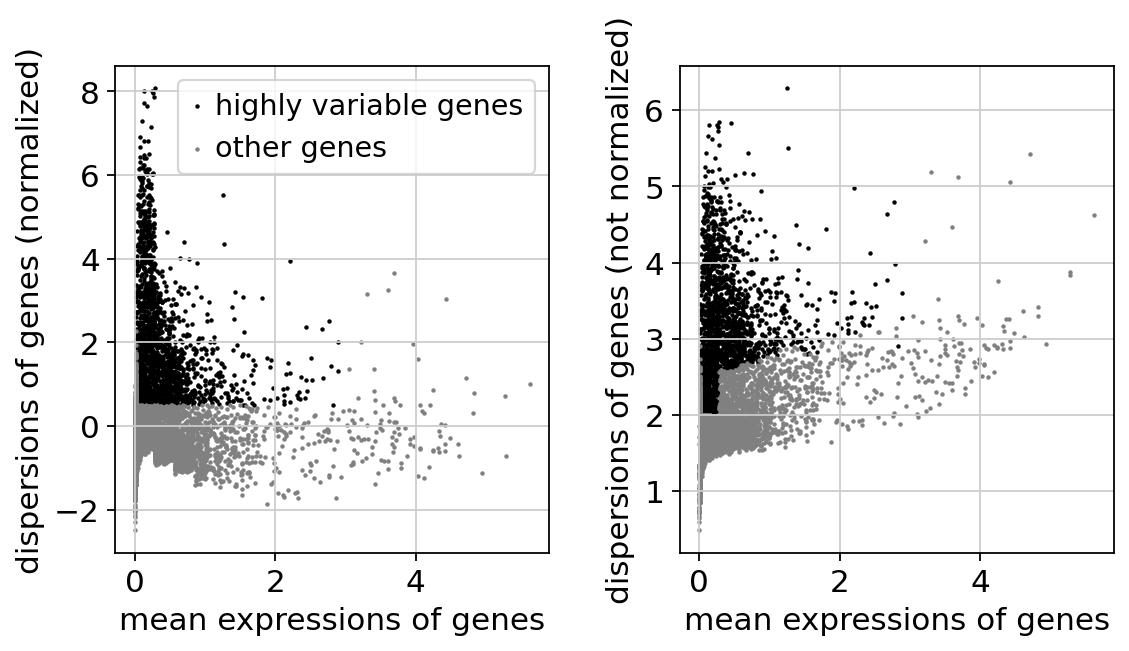

In [18]:
sc.pl.highly_variable_genes(adata)

Utilizando o atributo `.raw` do objeto AnnData podemos armazenar os dados da expressão gênica normalizada e logaritmizada para uso posterior em testes diferenciais e visualizações da expressão de genes. Isso simplesmente congela o estado do objeto AnnData.

<div class="alert alert-info">

**Nota**
Você pode chamar o objeto armazenado no comando anterior utiizando `.raw.to_adata()`.

</div>    

In [19]:
adata.raw = adata

In [20]:
#adata = adata.raw.to_adata()

<div class = "alert alert-info">

**Nota**
    
Se você não seguir com a correção dos dados utilizando `sc.pp.regress_out` e escalá-los via` sc.pp.scale`, você não precisa utilizar `.raw`.

O resultado da detecção anterior de genes altamente variáveis é armazenado como uma anotação em `.var.highly_variable` e auto-detectado pelo PCA e, portanto,` sc.pp.neighbors` e ferramentas de manifold / gráfico subsequentes. Nesse caso, a etapa * realmente fazendo a filtragem * abaixo também é desnecessária.

</div>

Realmente fazendo a filtragem

In [21]:
adata = adata[:, adata.var.highly_variable]

In [22]:
adata

View of AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

Regressar os efeitos da contagem total por célula e a porcentagem de genes mitocondriais expressos. Dimensione os dados para a variação da unidade.

In [23]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


    finished (0:00:08)


Dimensione cada gene de acordo com a variação unitária. Os valores que excedem o desvio padrão 10, vão ser cortados

In [24]:
sc.pp.scale(adata, max_value=10)

## Análise de componetes principais (Principal component analysis - PCA)

Aplicando a redução dimensional utilizando a análise de componentes principais (PCA), que revela os principais eixos de variação e diminui o ruído dos dados.

In [25]:
sc.tl.pca(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


Podemos fazer um gráfico de dispersão nas coordenadas PCA, mas não o usaremos mais tarde

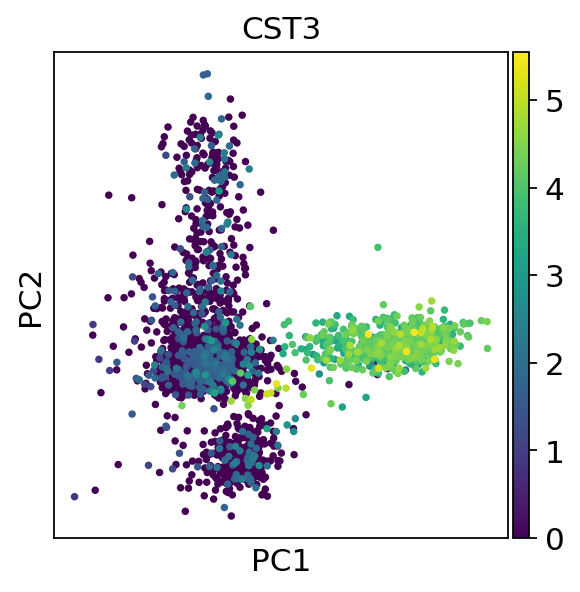

In [26]:
sc.pl.pca(adata, color='CST3')

Vamos inspecionar a contribuição de cada componente principal (PC) individualmente para a variância total dos dados. Isso nos dá informações sobre quantos PCs devemos considerar para calcular as relações de vizinhança das células, por exemplo, usado na função de agrupamento `sc.tl.louvain ()` ou tSNE `sc.tl.tsne ()`. Em nossa experiência, muitas vezes, uma estimativa aproximada do número de PCs é muito satisfatória.

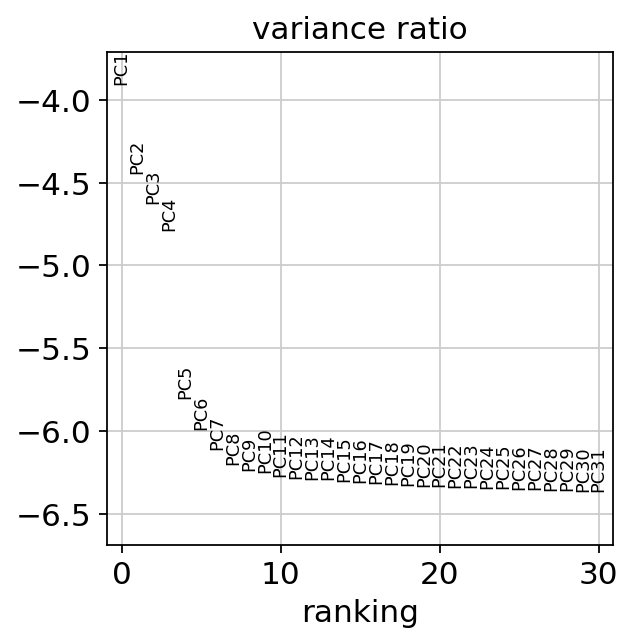

In [27]:
sc.pl.pca_variance_ratio(adata, log=True)

Salve o resultado.

In [28]:
adata.write(results_file)

In [29]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Calculando o grafo de vizinhança

Vamos calcular o grafo de vizinhança das células usando a representação PCA da matriz de dados. Você pode simplesmente usar os valores padrão aqui. Para reproduzir os resultados de Seurat, vamos usar os seguintes valores.

In [30]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


## Reduzindo o grafo de vizinhança

Nós recomendadmos a redução do grafo em 2 dimensões usando UMAP ([McInnes et al., 2018] (https://arxiv.org/abs/1802.03426)), como faremos abaixo. É potencialmente mais fiel à conectividade global do manifold do que tSNE, ou seja, preserva melhor as trajetórias. Em algumas ocasiões, você ainda pode observar clusters desconectados e violações de conectividade semelhantes. Eles geralmente podem ser corrigidos executando:
```
tl.paga(adata)
pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
tl.umap(adata, init_pos='paga')
```

In [31]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


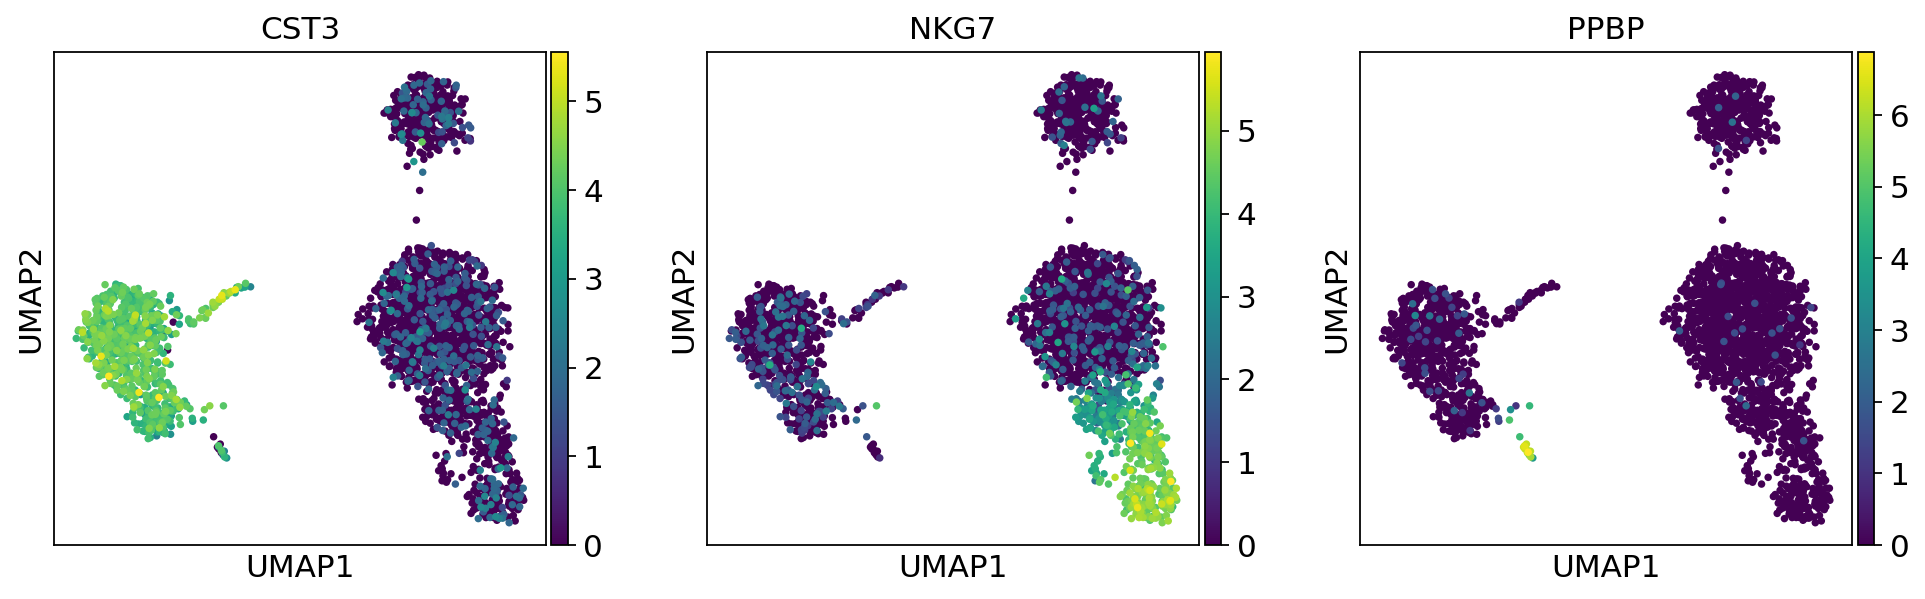

In [32]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

Conforme definimos o atributo `.raw` de` adata`, os gráficos anteriores mostraram a expressão do gene "bruta" (normalizada, logaritmizada, mas não corrigida). Você também pode representar graficamente a expressão do gene em escala e corrigida, declarando explicitamente que não deseja usar `.raw`. Ou seja, o padrão é da função é utilizar o `.raw`

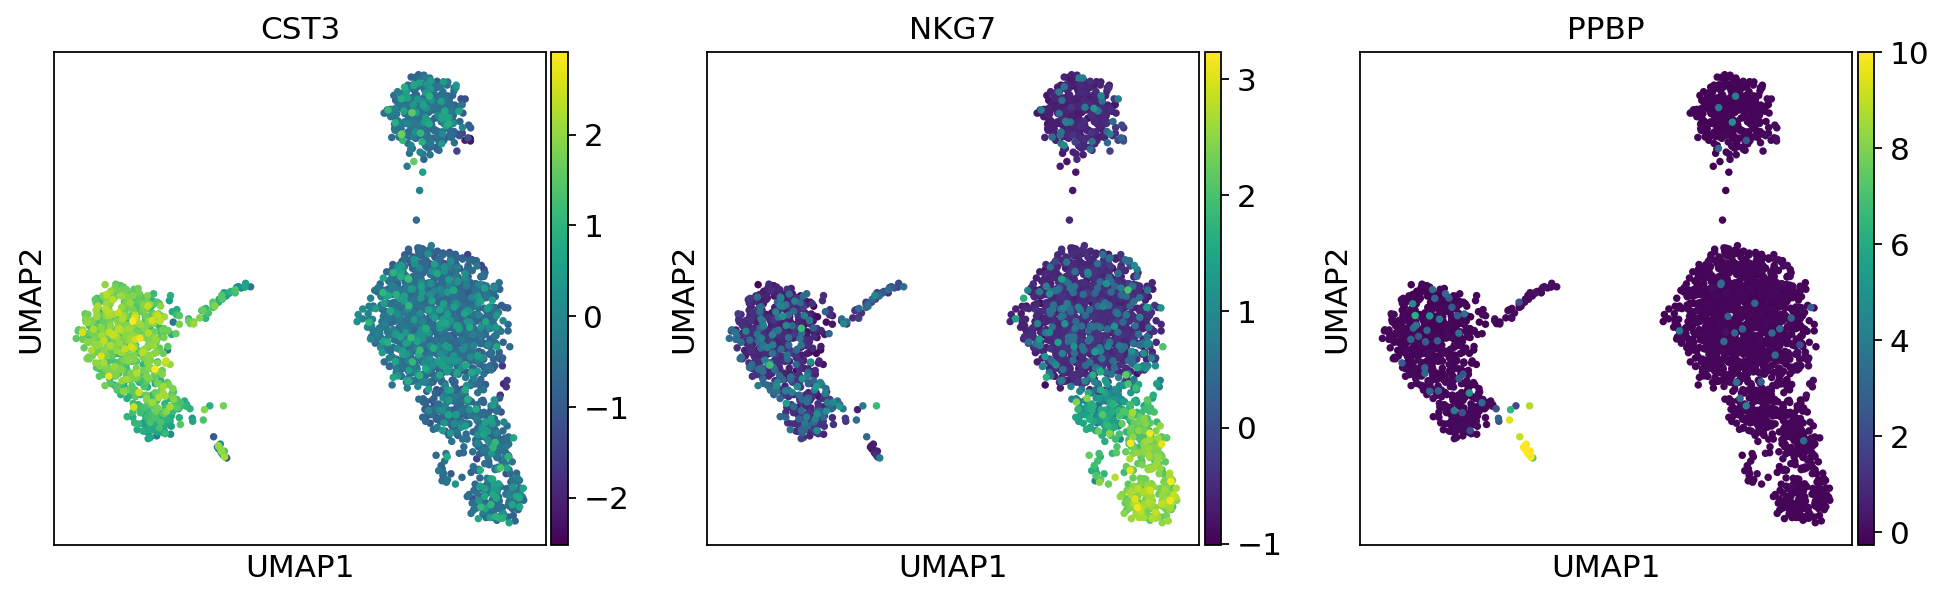

In [33]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

## Formação dos clusters no grafo de vizinhança

Como Seurat e muitos outros, recomendamos o método de agrupamento de grafos de Leiden (detecção de comunidade baseada na otimização da modularidade) por [Traag * et al. * (2018)] (https://scanpy.readthedocs.io/en/latest/references .html # traag18). Observe que o agrupamento de Leiden agrupa diretamente o gráfico de vizinhança das células, que já calculamos na seção anterior. Ou seja, ele já considera os vizinhos de uma célula como pertencentes a um mesmo cluster

In [34]:
!pip install leidenalg
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


Plote os clusters, que concordam muito bem com o resultado de Seurat que obtemos com o Umap.

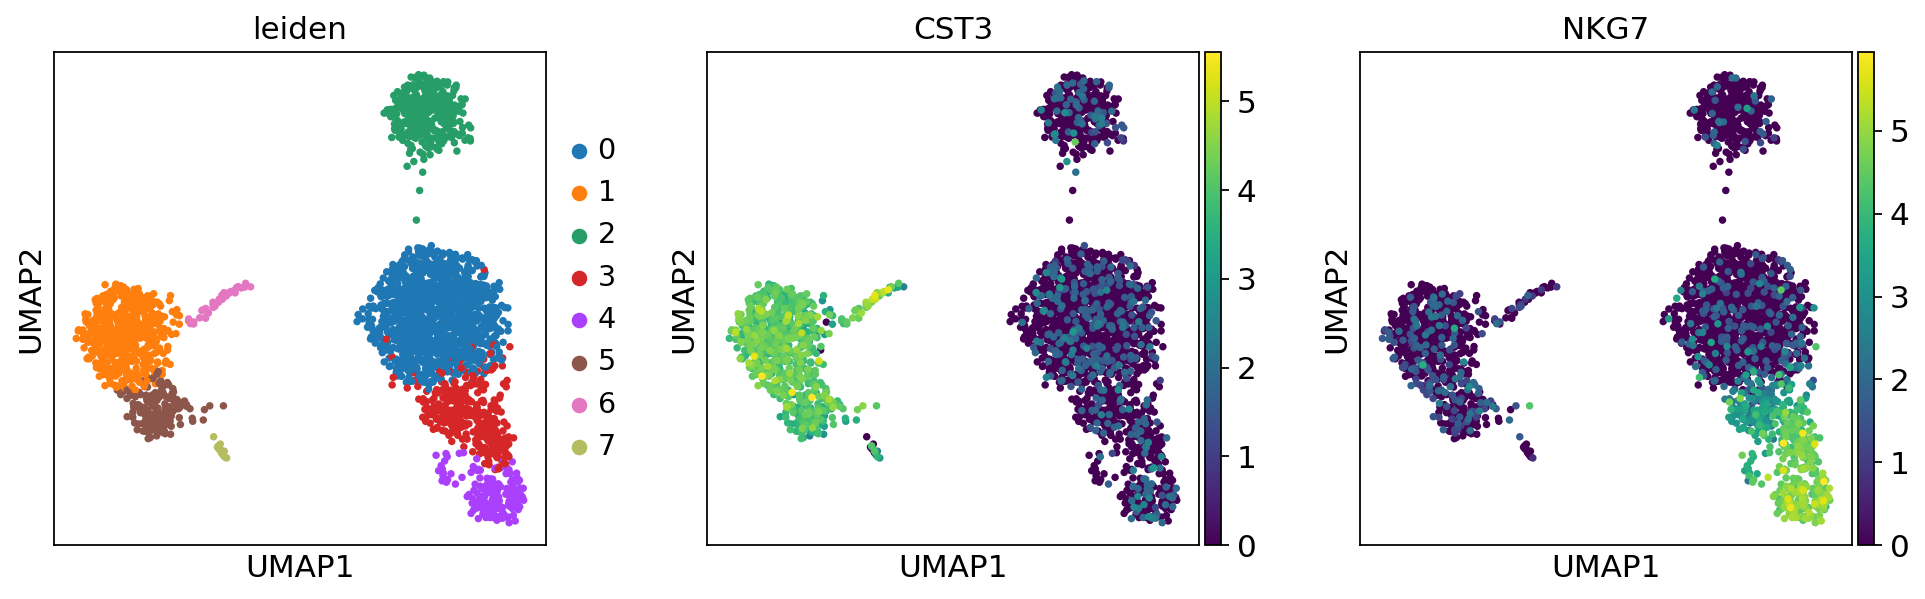

In [35]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

Salvamos o resultado

In [36]:
adata.write(results_file)

## Busca pelos genes marcadores

Vamos calcular um ranking para os genes altamente diferenciais em cada cluster. Existem vários métodos para fazermos isso. Aqui testaremos 3 deles a quesite de comparação. 

Para isso, utilizaremos a função `sc.tl.rank_genes_groups(adata, 'leiden', method='')`, alterando o método em `method=''`

O método mais simples e rápido de fazer isso é o teste t (t-test).

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


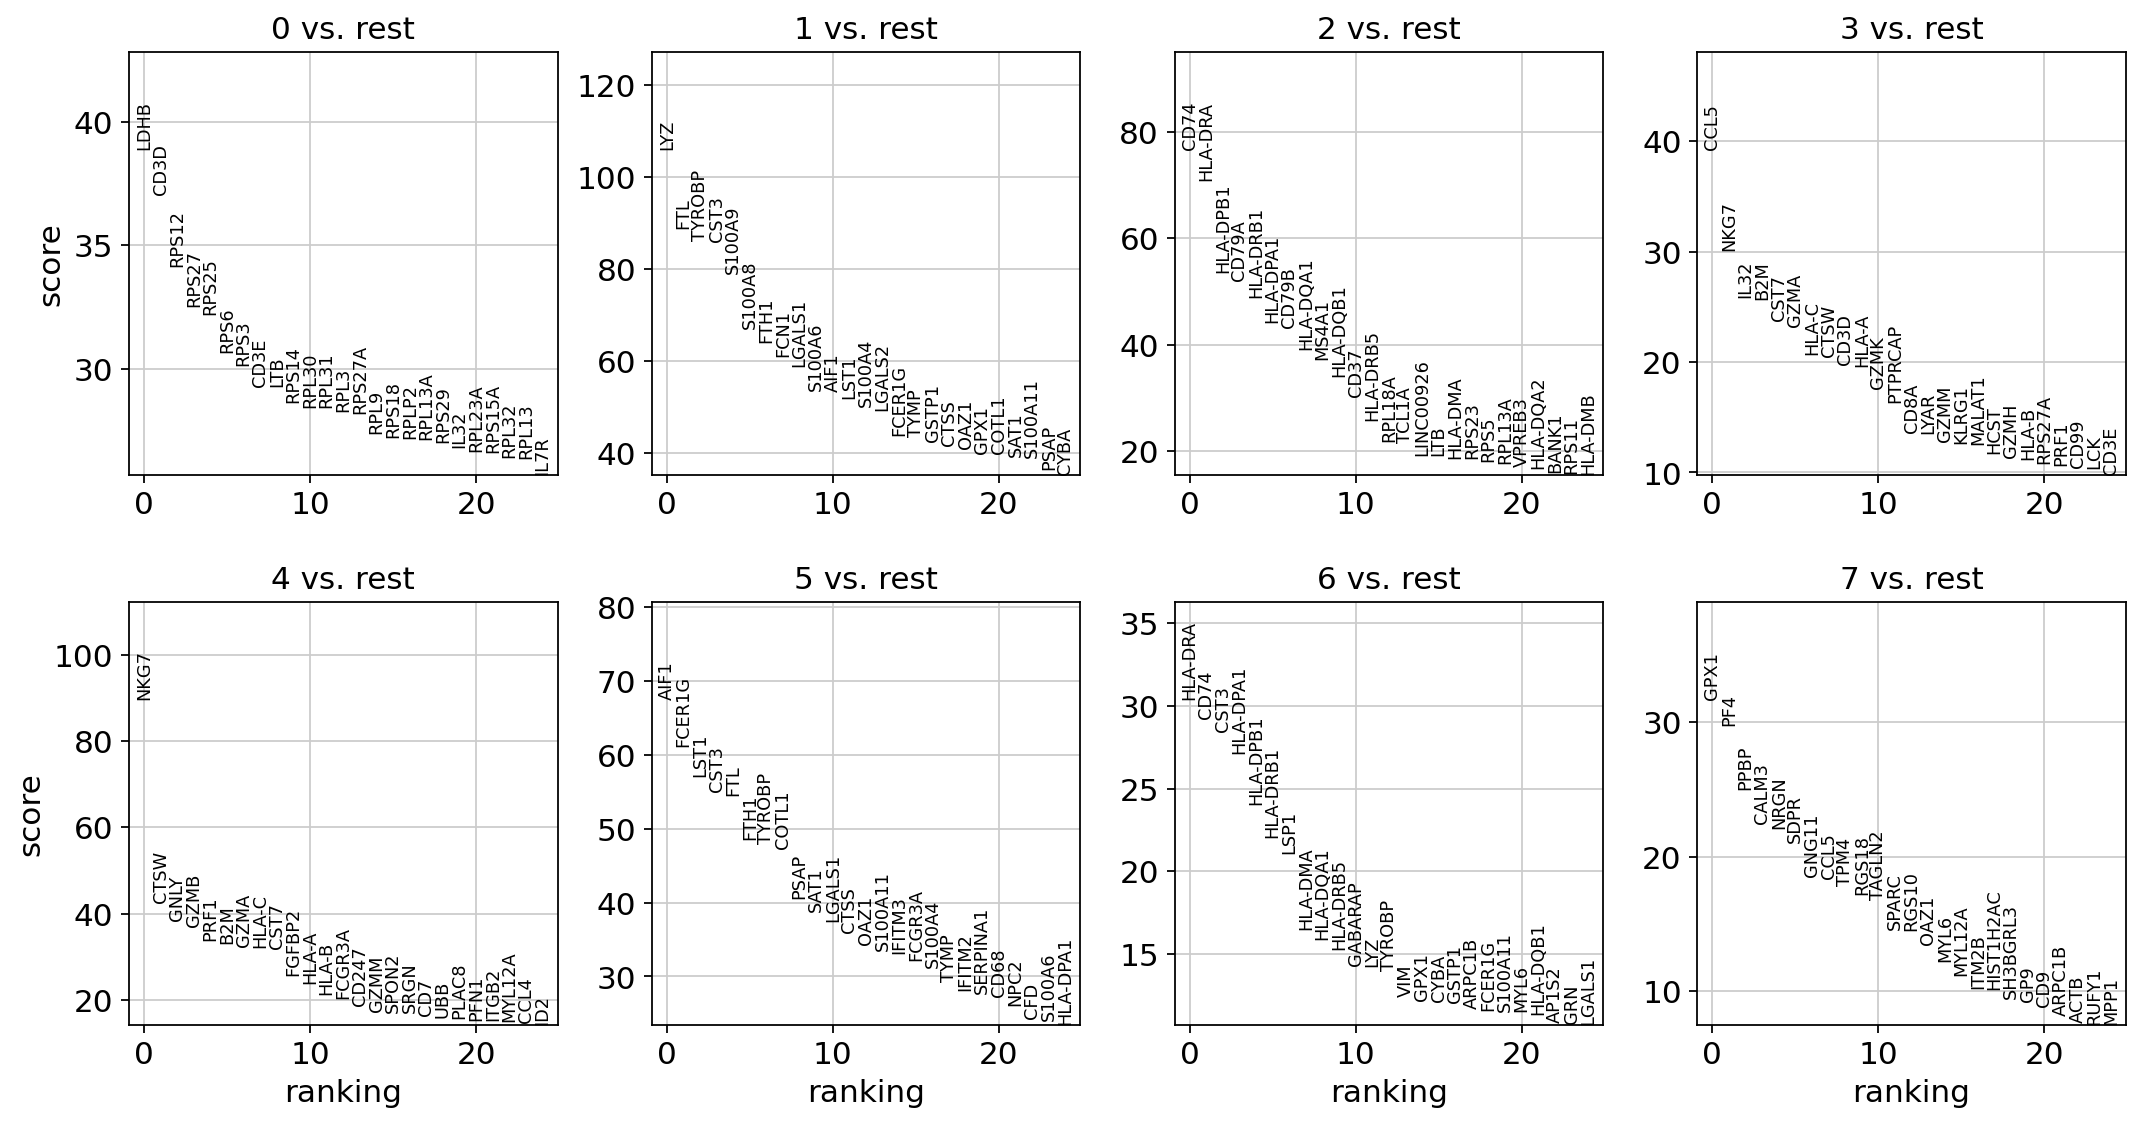

In [37]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [38]:
sc.settings.verbosity = 2  # reduce the verbosity

Outro método interessante para encontrar esses genes altamente variáveis é o chamado teste da [soma da classificação de Wilcoxon (Mann-Whitney-U)](https://de.wikipedia.org/wiki/Wilcoxon-Mann-Whitney-Test), cujo resultado é muito semelhante ao que obtivemos anteriormente. Recomendamos o uso do último em publicações, consulte, por exemplo, [Sonison & Robinson (2018)](https://doi.org/10.1038/nmeth.4612). Você também pode considerar pacotes de testes diferenciais muito mais poderosos, como MAST, limma, DESeq2 e, para python, o diffxpy recente.

ranking genes
    finished (0:00:02)


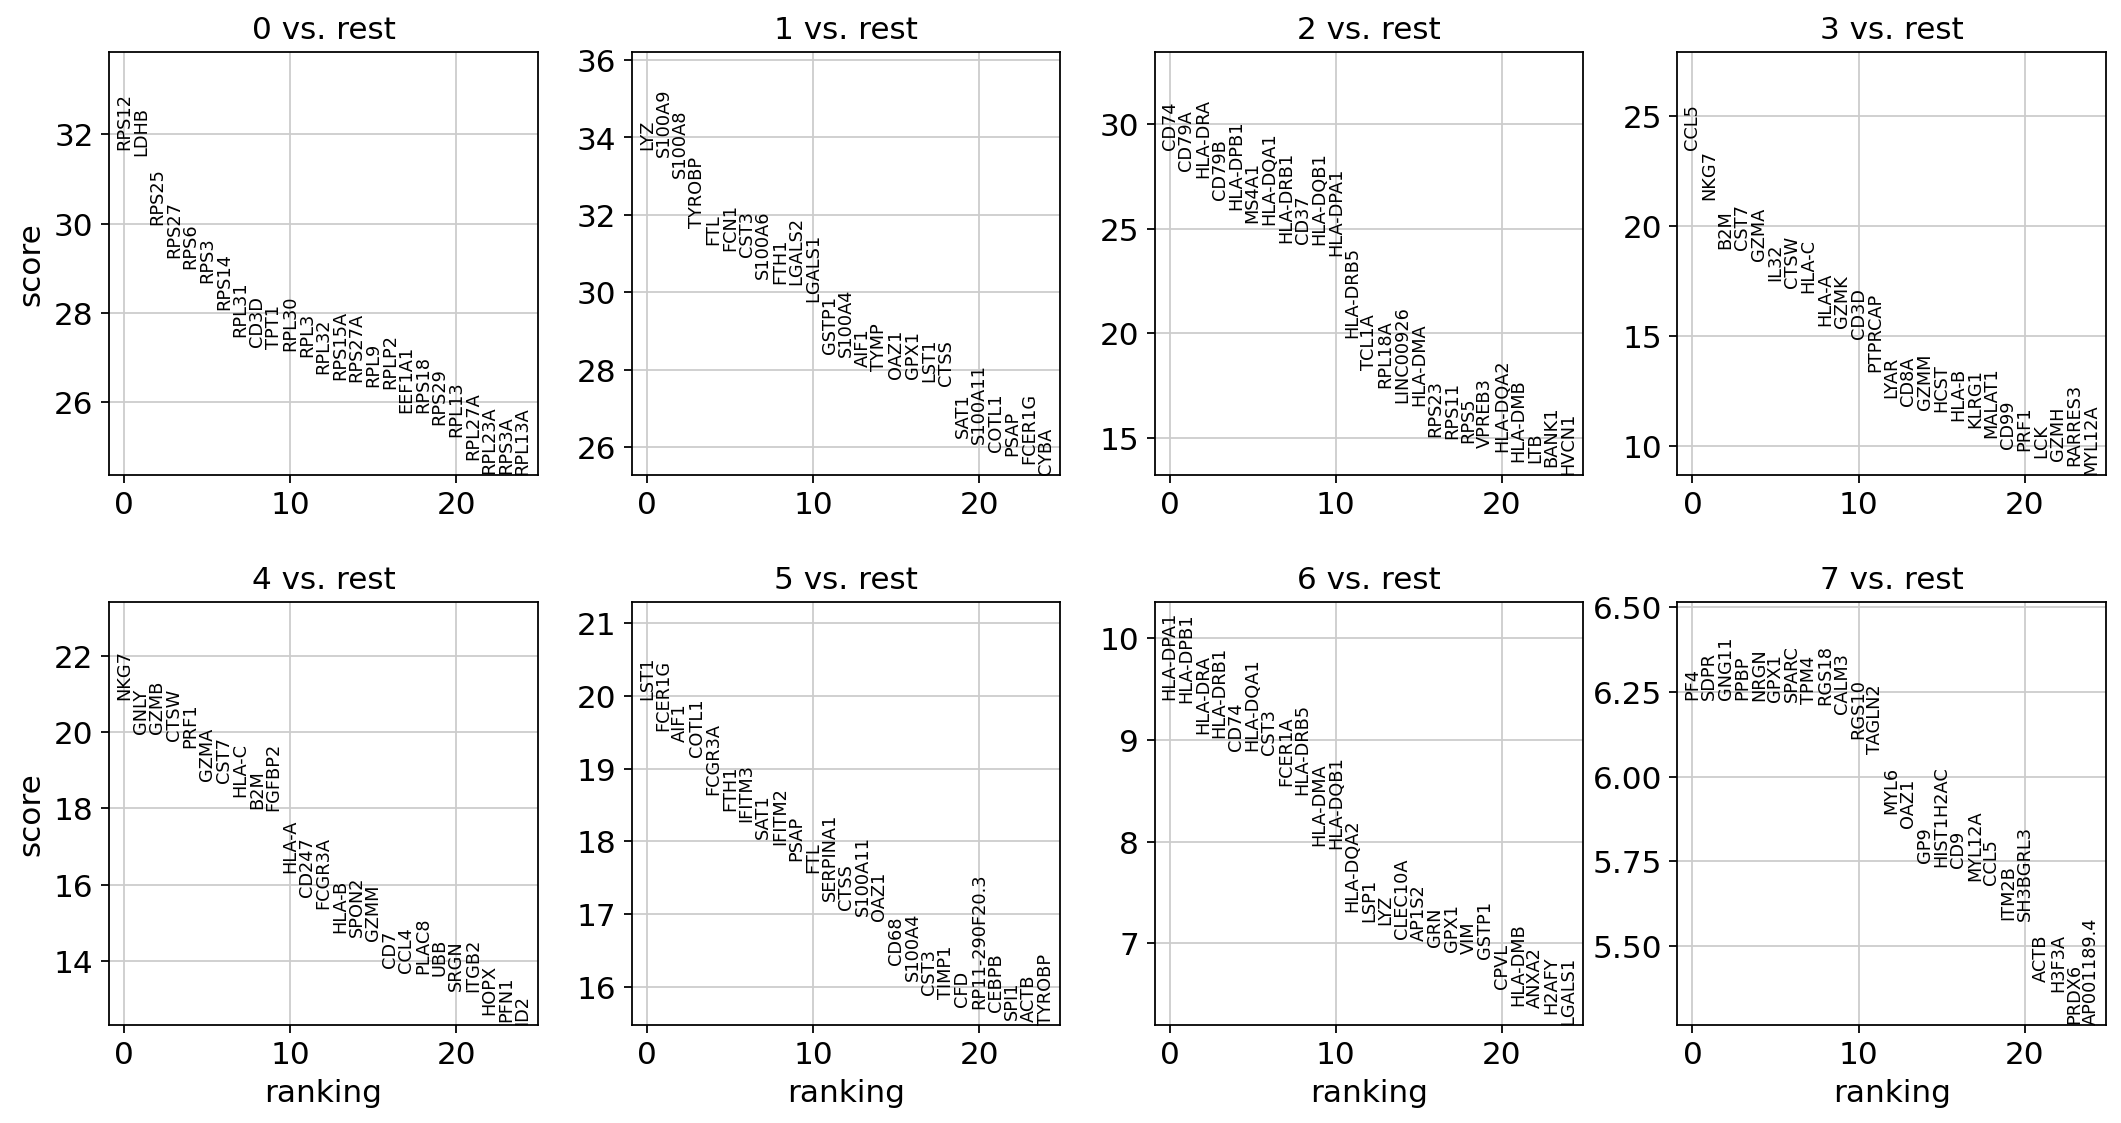

In [39]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Salve os resultados

In [40]:
adata.write(results_file)

Como alternativa, vamos classificar os genes usando a regressão logística, nosso terceiro e último método. Por exemplo, isso foi sugerido por [Natranos et al. (2018)](https://doi.org/10.1101/258566). A diferença essencial é que aqui usamos uma abordagem multivariada, enquanto os testes diferenciais convencionais são univariados. [Clark et al. (2014)](https://doi.org/10.1186/1471-2105-15-79) tem mais detalhes.

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg', max_iter=2000)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

ranking genes


Com exceção de * IL7R *, que só é encontrado pelo teste t e * FCER1A *, que só é encontrado pelas outras duas abordagens, todos os genes marcadores são recuperados em todas as abordagens. Abaixo a correlação desses genes:

Louvain Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 | CD8A |	CD8 T cells
4 | GNLY, NKG7 | 	NK cells
5 | FCGR3A, MS4A7 |	FCGR3A+ Monocytes
6 | FCER1A, CST3 |	Dendritic Cells
7 | PPBP |	Megakaryocytes

Vamos também definir uma lista de genes marcadores para referência posterior.

In [ ]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',  
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [ ]:
type(marker_genes)

Recarregue o objeto que foi salvo com o resultado do teste Wilcoxon Rank-Sum.

In [ ]:
adata = sc.read(results_file)

In [ ]:
results_file

Mostre os top 10 genes mais variáveis por cluster 0, 1, ..., 7 em um dataframe.

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

Obtenha uma tabela com as pontuações e clusters.

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

Compare com um único cluster.

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

Se quisermos uma visão mais detalhada de um determinado grupo, use `sc.pl.rank_genes_groups_violin`.

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

Recarregue o objeto que calculou a expressão diferencial comparando-o com o restante dos grupos.

In [ ]:
adata = sc.read(results_file)

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

Se você quiser comparar um determinado gene entre grupos, use o seguinte.

In [ ]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

Faça a anotação de cada cluster com seu tipo celular

In [ ]:
adata

In [ ]:
adata.obs['leiden']

In [ ]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T', 
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

In [ ]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='PBMC 3k', frameon=False, save='')

Agora que anotamos os tipos de células, vamos visualizar os genes marcadores.

In [ ]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

Aqui também faremos um violin plot bem compacto.

In [ ]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);

Durante a nossa análise, o nosso objeto AnnData acumulou as seguintes anotações.

In [ ]:
adata.write(results_file)

In [ ]:
adata.write(results_file, compression='gzip')  # `compression = 'gzip'` economiza espaço em disco, mas retarda a escrita e subsequente leitura

Podemos também armazenar nossos dados em um arquivo `h5ad`, gerando uma visão geral aproximada do nosso objeto AnnData. - para mais detalhes veja [aqui](https://github.com/theislab/scanpy_usage/blob/master/170505_seurat/info_h5ad.md). 

Se você deseja compartilhar este arquivo com pessoas que desejam apenas usá-lo para visualização, uma maneira simples de reduzir o tamanho do arquivo é removendo a densa matriz de dados dimensionada e corrigida. O arquivo ainda contém os dados brutos usados nas visualizações em `adata.raw`.

In [ ]:
adata = adata.raw.to_adata()

In [ ]:
adata

In [ ]:
adata.write('write/pbmc3k_raw.h5ad')

In [ ]:
adata.raw.to_adata().write('./write/pbmc3k_raw.h5ad')

Se você deseja exportar para "csv", tem as seguintes opções:

In [ ]:
adata

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges', 'pvals', 'pvals_adj']})

In [ ]:
df.to_csv('write/marker_genes.csv',)

In [ ]:
result

In [ ]:
df

In [ ]:
results_file

In [ ]:
# Exportar campos únicos da anotação de observações
adata.obs[['n_counts', 'leiden']]. to_csv ('./write/pbmc3k_corrected_louvain_groups.csv')

# Exportar colunas únicas da anotação multidimensional
adata.obsm.to_df () [['X_pca1', 'X_pca2']]. to_csv ('./write/pbmc3k_corrected_X_pca.csv')

# Ou exporte tudo, exceto os dados usando `.write_csvs`.
# Defina `skip_data = False` se você também deseja exportar os dados.
adata.write_csvs (results_file [: - 5],)